# IMDB Text Classification

In this notebook we want to explore how to do text classification. This involves some fundamental text preprocessing steps that are common for NLP (natural language processing) tasks. We will work with the IMDB dataset, which is luckily [part of the Keras datasets library](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb).

This dataset consists of 50.000 movie reviews and our goal is to classify whether the review is positive or negative. We will work through the problem step by step and see more explanations along the way. Let's first import the necessary libraries:

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


As explained before we are using `keras` and with that come [some wonderful datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). We first select the dataset and then download the data and split it into training and test sets.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

What is noteworthy is the `num_words=10000` property. This limits the data to only contain the 10.000 most frequently occurring words. While it may seem like we are losing some amount of information by this (which is absolutely true) it is simply done for computation purposes.

## Let's look at the data

Now that we have the training and testing data at our fingertips we will have a look at it. First of all let's check the size of the respective sets:

In [3]:
print("Training set size: {}, Test set size: {}".format(len(train_data), len(test_data)))
print("Training labels mean: {}, test labels mean: {}".format(train_labels.mean(), test_labels.mean()))

Training set size: 25000, Test set size: 25000
Training labels mean: 0.5, test labels mean: 0.5


So we see that all the data (50.000 reviews) is not only evenly split but each set also has an even distribution of positive and negative reviews.

So let's take a look at how much words a review might have:

In [4]:
for i in range(5):
    print(len(train_data[i]), end=" ")

218 189 141 550 147 

So we already see that our reviews are of various length. This makes it difficult to work with as normal systems need an input of constant size. We have a pretty simple way to deal with it but let's first take a look at a real review:

In [5]:
" ".join([str(train_data[0][x]) for x in range(len(train_data[0]))])

'1 14 22 16 43 530 973 1622 1385 65 458 4468 66 3941 4 173 36 256 5 25 100 43 838 112 50 670 2 9 35 480 284 5 150 4 172 112 167 2 336 385 39 4 172 4536 1111 17 546 38 13 447 4 192 50 16 6 147 2025 19 14 22 4 1920 4613 469 4 22 71 87 12 16 43 530 38 76 15 13 1247 4 22 17 515 17 12 16 626 18 2 5 62 386 12 8 316 8 106 5 4 2223 5244 16 480 66 3785 33 4 130 12 16 38 619 5 25 124 51 36 135 48 25 1415 33 6 22 12 215 28 77 52 5 14 407 16 82 2 8 4 107 117 5952 15 256 4 2 7 3766 5 723 36 71 43 530 476 26 400 317 46 7 4 2 1029 13 104 88 4 381 15 297 98 32 2071 56 26 141 6 194 7486 18 4 226 22 21 134 476 26 480 5 144 30 5535 18 51 36 28 224 92 25 104 4 226 65 16 38 1334 88 12 16 283 5 16 4472 113 103 32 15 16 5345 19 178 32'

Well if that isn't a positive review I don't know what is!? As we see these values are encoded. Each of these integers is standing for a word but because it is easier to work with integers than with strings the words are encoded. 

Fortunately we can get a dictionary of the mappings from words to integers so we can use those to translate our review into a more human readable form.

In [6]:
word_index = imdb.get_word_index()

word_index["and"]

2

So it works that we can find the encoding for a certain word but of course we want to also be able to decode the integers into the real word strings. We write a little helper function for this. 

But first we need to reserve some integer encodings for some basic things and therefore increase all the other integer encodings. Especially we need the following:

* `<PAD>`: As mentioned before we need to find a way to make our input one similar length. We will use padding for this which will become more clear in just a bit
* `<START>`: Pretty self-explanatory but we need an indication where our review starts
* `<UNK>`: This will represent the *unknown* encoding. Remember that we limited our vocabulary size to only the 10.000 most frequent words. All other words will get this encoding.
* `<UNUSED>`: also self-explanatory, used for unused words

So let's create all of this:

In [7]:
word_index = {k: (v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3


reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])

def decode_review(review):
    return " ".join([reverse_word_index.get(x, "?") for x in review])

Now we can finally try to read the whole movie review which was cryptic before (Spoiler alert: it really is positive).

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Preprocess the data

In order to start building up and eventually training our model we need to do some preprocessing. First off we need a uniform input length for our network. One way would be to create a sort of "one-hot-encoding" where one means "all-words-appearing-in-the-review". This might sound intuitive first but will create a massive matrix of the size `num_words * num_reviews`.

We can use a simpler approach and simple select a certain size and add padding to reviews that are smaller and cut off longer reviews. We will lose some information but hopefully can classify from the amount of words already analyzed. But how do we do that?

I'm glad you asked! Again `keras` comes to the rescue as it offers a `preprocessing.sequence.pad_sequences` method to do all this work for us. So let's use it for our `train_data` and `test_data`:

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding="post",
                                                      maxlen=256)

In [10]:
for i in range(5):
    print(len(train_data[i]), end=" ")

256 256 256 256 256 

We can see that now all reviews are of the same length. With this we can start building our model.

## Building the model

We will use a plain neural network here which is the `keras.Sequential()` model but it has some special layers included. Let's first think of what we need to go through here:

1. Make use of the encodings and the word information we have
2. Use hidden units to learn how to predict from the data
3. Get a prediction of 0 ("negative") or 1 ("positive") in the end (which will be represented by a probability)

We can tackle this with the following model and take a look at each layer in a second:

In [11]:
vocab_size = 10000

model = keras.Sequential()
model.add(layers.Embedding(vocab_size, 16))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(16, activation=tf.nn.relu))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


So let's go through the layers one-by-one:

* `Embedding`: The way we represent our words are in a multi-dimensional space. The idea here is the same as in the [word2vec](https://en.wikipedia.org/wiki/Word2vec) concept where each word is a vector in that space (in this case 16 dimensional). If we have this representation we can cluster similar words closer to each other and then infer some meaning by their (Euclidean) distances.

* `GlobalAveragePooling1D`: The idea of a pooling layer is rather simple: in order to reduce the dimensionality we can combine multiple values and take their average (if we look at convolutions taking the maximum is more common).

* `Dense`: This a just a standard fully-connected layer. The first one has 16 hidden units and the `tf.nn.relu` activation function which is the standard for fully-connected layers. The second one only 1 hidden unit and uses a `tf.nn.sigmoid` activation. In case you were wondering why that is, the `tf.nn.sigmoid` function maps a value into the range of 0 and 1. We use this because our desired output is a probability p whether or not our review was positive (or probability 1-p to indicate whether it was negative).

(Note: The `model.summary()` command gives us a great overview of our model and the different layers. Also the indication of the amount of trainable parameters can be really helpful to get a feel about the size of our model.)

## Loss function and optimizer

In order to train our model we need to first `compile` it. Here it is necessary to specify 3 more properties:

* `optimizer`: Our model learns by adjusting the parameters that are contained inside our different layers. The `optimizer` specifies in which direction and by how much we need to adjust these parameters and is therefore one key element as it is key in the learning phase of our network. The `adam` optimizer is also one of the standard optimizers used in neural network training.

* `loss`: After we predict an output in our training phase we want our model to get better. This is why we need to calculate a `loss` which can be understood as: How far was our prediction off? This is crucial so that we can then use the optimizer to adjust our parameters. As we have a single probability output we choose the `binary_crossentropy` but this is highly dependent on the use-case.

* `metrics`: We want to know how well we are predicting. In this case it is really simple as we can either be right or wrong with our prediction. This is why we choose the `accuracy` metric to evaluate the performance of our model.

In [12]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["acc"])

## Create validation set

In neural network training we have a high risk of **overfitting**. This means that the network might learn certain properties of the training set that are not applicable to the general problem. The reason for this is that the network has so many parameters that it has the capacity to do so. 

There are several techniques to detect and prevent this problem. One that is used here is to create a **validation set**. We take portion of the data away from our **training set** and keep it hidden from the network during the training phase. Therefore it won't be able to overly adjust to these samples. After we trained the network we evaluate on this validation set. This gives a better indication on the performance of our algorithm as its properties could not have been learnt by heart by the network.

(Note: it is important to split the data in a way that both datasets are still representative of the problem. Otherwise it will lead to a whole lot of different problems.)

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train model

Now we are all set to finally start training our model with the `model.fit()` function. However there is still some more parameters to set and tweak:

* `epochs`: An epoch is one run through our training procedure where the network sees the whole data. You might say it is enough to see all data once but it is common practice to make multiple runs (in some cases even thousands) depending on the size of your dataset. This will increase the performance of our network but we need to be careful to not be overfitting.

* `batch_size`: We use so called *mini-batches* of size 512 to send throught the network at a time. This speeds up the training procedure.

* `validation_data`: As mentioned before the validation data is used to get a sense of how well our network is performing on unseen data.

* `verbose`: This is just a `Tensorflow` property to increase the output we see during training.

In [14]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 44us/sample - loss: 0.6919 - acc: 0.5099 - val_loss: 0.6898 - val_acc: 0.5391
Epoch 2/40
15000/15000 [==============================] - 0s 12us/sample - loss: 0.6867 - acc: 0.5604 - val_loss: 0.6826 - val_acc: 0.6153
Epoch 3/40
15000/15000 [==============================] - 0s 13us/sample - loss: 0.6758 - acc: 0.6163 - val_loss: 0.6689 - val_acc: 0.6350
Epoch 4/40
15000/15000 [==============================] - 0s 12us/sample - loss: 0.6579 - acc: 0.6651 - val_loss: 0.6488 - val_acc: 0.6594
Epoch 5/40
15000/15000 [==============================] - 0s 11us/sample - loss: 0.6335 - acc: 0.6975 - val_loss: 0.6237 - val_acc: 0.7102
Epoch 6/40
15000/15000 [==============================] - 0s 11us/sample - loss: 0.6046 - acc: 0.7344 - val_loss: 0.5958 - val_acc: 0.7416
Epoch 7/40
15000/15000 [==============================] - 0s 12us/sa

## Evaluate the model

Of course we need to evaluate our model and therefore we use the **test set**. This is needed because this data is something the network has never seen and (in the case it is representative of our problem space) gives an intuition how well the model will generalize.

(Note: if you are confused by the difference between *validation* and *test* set here is an explanation: the validation set is used during the training phase to evaluate the performance after each *epoch*. It is therefore data that the network has seen before and if we will optimize for accuracy on that we might be overfitting to the validation set. The *test* set is something the algorithm has never seen before and by that a good way for a final evaluation.)

In [15]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 32us/sample - loss: 0.3696 - acc: 0.8680
[0.36963458097457885, 0.86796]


So with this simple model we already get a pretty good accuracy of around `87 %`!

## Closer look at the history

Finally let's take a closer look at the development of the training and the validation loss and accuracy over time. This gives a solid indication if we were overfitting to our training set.

In [16]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

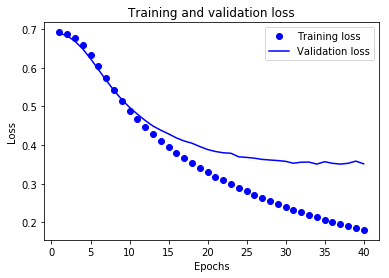

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

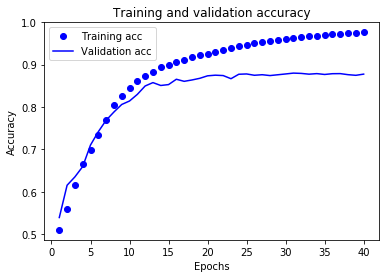

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We can see that after ~20 epochs the accuracy on our validation set pretty much stagnates. As the accuracy on the training set is still increasing we have a high chance of overfitting to our training data. This is a wonderful example of why a validation set can be really helpful at times.

Of course now we still would need to tackle this issue. This is beyond the scope of this little demonstration but one solution could be to do **early-stopping**. This means to simply evaluate the validation set accuracy over time and if it decreases (or only increases by very small numbers) we stop training as we won't get better. However there are also many other approaches to tackle overfitting.

## Final thoughts

This tutorial was mostly taken from [the tensorflow tutorials site](https://www.tensorflow.org/tutorials/keras/basic_text_classification) so I want to give full credit to them. However I tried to explain some more details at certain steps to make it more clear if you are just getting started or maybe not so proficient on the basics of neural networks and the whole training procedure.